In [1]:
import numpy as np
import matplotlib.pyplot as plt
from glob import glob

In [2]:
# fig, axes = plt.subplots(2, 2, figsize=(24,14))

# for folder in glob('sims/*'):
#     ells = np.load(f'{folder}/ells.npy')
#     cl_fb = np.load(f'{folder}/cl_fb.npy')
#     cl_fbt = np.load(f'{folder}/cl_fbt.npy')
    
#     n_sims = int(folder.strip('sims/'))

# ########################
# #     fbt_l, fbt_m, fbt_h = np.percentile(cl_fbt, [2.5,50,97.5], axis=0) #95% confidence interval
# #     fb_l, fb_m, fb_h = np.percentile(cl_fb, [2.5,50,97.5], axis=0) 
                 
# #     percent_error = (fbt_h-fbt_l)/fbt_m
# #     axes[0][0].plot(ells, (fbt_h-fbt_l)/fbt_m, linestyle='dashed', label=n_sims)
# #     axes[0][1].plot(n_sims, np.median(percent_error), marker='o')
# ########################    

#     fbt_mean = np.mean(cl_fbt, axis=0)
#     fbt_std = np.std(cl_fbt, axis=0)

#     fb_mean = np.mean(cl_fb, axis=0)
#     fb_std = np.std(cl_fb, axis=0)
    
#     axes[0][0].plot(ells, fbt_std/n_sims/fbt_mean, linestyle='dashed', label=n_sims)
#     axes[0][1].plot(n_sims, np.mean(fbt_std/n_sims/fbt_mean), marker='o')

    
# #     fbc_m = np.zeros_like(fb_m)
# #     fbc_l = np.zeros_like(fb_l)
# #     fbc_h = np.zeros_like(fb_h)

# #     for i in range(len(ells)):
# #         cl_bin = []
# #         for j in range(cl_fb.shape[0]):
# #             for k in range(cl_fbt.shape[0]):
# #                 cl_bin.append(cl_fb[:,i][j]/cl_fbt[:,i][k])

# #         fbc_l[i], fbc_m[i], fbc_h[i] = np.percentile(cl_bin, [2.5,50,97.5])  
        
# #     inflation_per_ell = ((fbc_h-fbc_l)/fbc_m) / ((fb_h-fb_l)/fb_m)
                 
# #     axes[1][0].plot(ells, inflation_per_ell, linestyle='dashed', label=n_sims)
# #     axes[1][1].plot(n_sims, np.median(inflation_per_ell), marker='o')
                 
# axes[0][0].set_title('Transfer function error bar size vs ell')
# axes[0][0].set_xlabel('Ell')
# axes[0][0].set_ylabel('Errorbar size/value')
# # axes[0][0].set_ylim([0,1])
# axes[0][0].legend()
# axes[0][0].loglog()

# axes[0][1].set_title('Average transfer function error bar size (over all ells) vs n_sims')
# axes[0][1].set_xlabel('n_sims')
# axes[0][1].set_ylabel('Median errorbar size/value over all ells')
# axes[0][1].loglog()

# axes[1][0].set_title('Spectrum error bar inflation factor vs ell')
# axes[1][0].set_ylabel('Error bar inflation factor')
# axes[1][0].set_xlabel('Ell')
# axes[1][0].set_ylim([1,3])
# axes[1][0].legend()

# axes[1][1].set_title('Median spectrum error bar inflation factor (over all ells) vs n_sims ')
# axes[1][1].set_ylabel('Median inflation over all ells')
# axes[1][1].set_xlabel('n_sims')

# for ax in axes.flatten():
#     ax.grid()

In [3]:
# fig.savefig('errorbar_comparison.jpg')







/tmp/ipykernel_25192/458945046.py:11: RuntimeWarning: invalid value encountered in true_divide
  input_cl /= ell_input*(ell_input+1)/2/np.pi


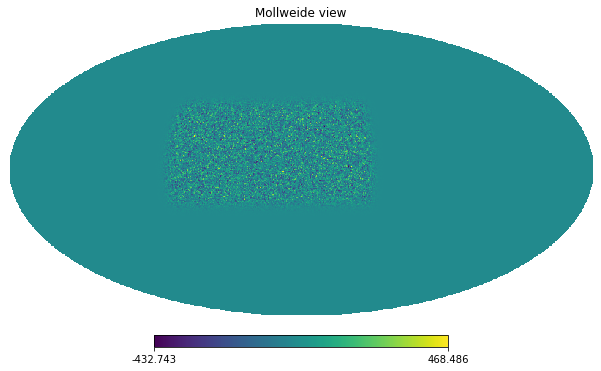

In [3]:
#Filter_replace == FT with 1 realization of Planck sky??
import methods
import pymaster as nmt
from importlib import reload
import healpy as hp


reload(methods)
ell_input, TT, TE, EE, BB, PP = np.loadtxt('cl.txt', unpack=True)
input_cl = np.array([TT, TE, EE, BB])
input_cl /= ell_input*(ell_input+1)/2/np.pi 
for c in input_cl: c[0] = 0

nside = 128
lmax = 3*nside-1
npix = 12*nside**2
pixels_lr, pixels_ud = methods.create_pixels()
rate = 10 #hz

TT = input_cl[0]
# input_map = hp.synfast(TT, nside)
input_map = hp.synfast(np.ones_like(TT), nside)

mask = np.zeros(npix)
mask[pixels_lr] = 1
mask_apo = nmt.mask_apodization(mask, 2.5, apotype="Smooth")    
hp.mollview(mask_apo * input_map)

In [88]:
reload(methods)
replaced_map = methods.map2map(input_map, pixels_lr, rate, noise_params=(0.5,2,100), noise_seed=0, subscan_poly_deg=10, replace=True, plot=False)

/scratch/yuyang/destripe/methods.py:81: RuntimeWarning: invalid value encountered in true_divide
  output_map[np.isnan(output_map)] = 0


In [56]:
filtered_map = methods.map2map(input_map, pixels_lr, rate, noise_params=(0.5,2,100), noise_seed=0, subscan_poly_deg=10, replace=False, plot=False)
filtered_planck_map = methods.map2map(input_map, pixels_lr, rate, noise_params=None, noise_seed=0, subscan_poly_deg=10, replace=False, plot=False)

lost_map = mask*input_map - filtered_planck_map 
recovered_map = filtered_map + lost_map

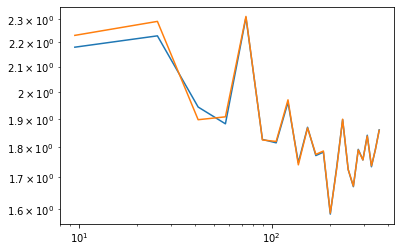

In [77]:
cl, ells = methods.map2cl(16, mask_apo, replaced_map)
cl_filt, ells = methods.map2cl(16, mask_apo, filtered_map)
cl_lost, ells = methods.map2cl(16, mask_apo, lost_map)

plt.loglog(ells, cl[0])
plt.loglog(ells, cl_filt[0]+cl_lost[0])

In [93]:
coadd1, coadd2 = methods.coadd_split(input_map, (pixels_lr, pixels_ud), rate, n_obs=10,noise_params=(0.5,2,100), noise_seed_start=0, replace=False)
cl_fb, ells = methods.map2cl(16, mask_apo, coadd1, coadd2)

/scratch/yuyang/destripe/methods.py:81: RuntimeWarning: invalid value encountered in true_divide
  output_map[np.isnan(output_map)] = 0


In [94]:
coadd1, coadd2 = methods.coadd_split(input_map, (pixels_lr, pixels_ud), rate, n_obs=10,noise_params=None, noise_seed_start=0, replace=False)
cl_fbt, ells = methods.map2cl(16, mask_apo, coadd1, coadd2)

In [97]:
coadd1, coadd2 = methods.coadd_split(input_map, (pixels_lr, pixels_ud), rate, n_obs=10,noise_params=(0.5,2,100), noise_seed_start=0, replace=True)
cl_fr, ells = methods.map2cl(16, mask_apo, coadd1, coadd2)

/scratch/yuyang/destripe/methods.py:81: RuntimeWarning: invalid value encountered in true_divide
  output_map[np.isnan(output_map)] = 0


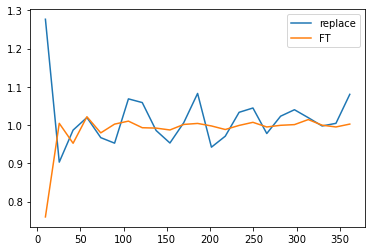

In [100]:
plt.plot(ells, cl_fr[0], label='replace')
plt.plot(ells, cl_fb[0]/cl_fbt[0], label='FT')
plt.legend()

In [8]:
m1 = mask_apo * hp.synfast(np.ones_like(TT), nside)
m2 = mask_apo * hp.synfast(np.ones_like(TT), nside)

In [10]:
(hp.map2alm(m1) + hp.map2alm(m2) - hp.map2alm(m1+m2)).max()

(4.440892098500626e-15+7.771561172376096e-16j)

In [37]:
output_map1 = methods.map2map(input_map, pixels_lr, rate, noise_params=None, noise_seed=0, subscan_poly_deg=10, plot=False, replace=False)
output_map2 = methods.map2map(input_map, pixels_ud, rate, noise_params=None, noise_seed=1, subscan_poly_deg=10, plot=False, replace=False)

output_map = (output_map1 + output_map2) / 2

/scratch/yuyang/destripe/methods.py:81: RuntimeWarning: invalid value encountered in true_divide
  output_map = PT(filtered_tod, pixels, npix)/PTP(pixels, npix)


In [48]:
f_l = hp.anafast(output_map)/hp.anafast(mask * input_map)

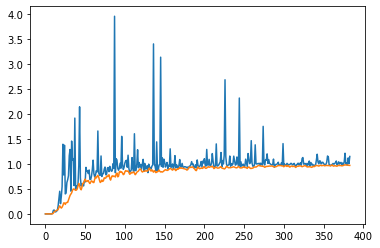

In [66]:
T_out = hp.map2alm(output_map)
T_in = hp.map2alm(mask * input_map)
f_lm = (T_out * T_in.conj()) / (T_in * T_in.conj())
plt.plot(hp.alm2cl(f_lm))
plt.plot(f_l)

In [82]:
debiased_cl = hp.anafast(output_map)/f_l
m_cl = hp.synfast(debiased_cl, nside)

In [83]:
debiased_alm = hp.map2alm(output_map)/f_lm
m_alm = hp.alm2map(debiased_alm, nside)

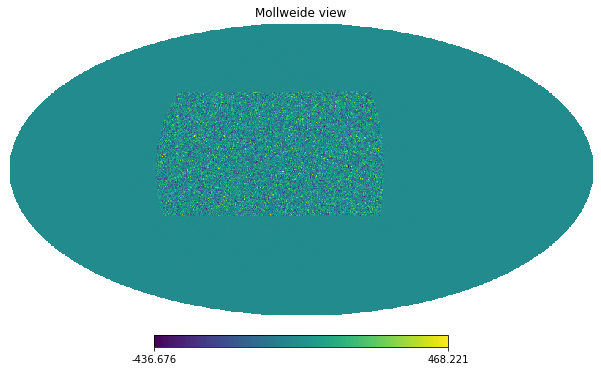

In [85]:
hp.mollview(m_alm)

In [76]:
residual = debiased_map - mask*input_map

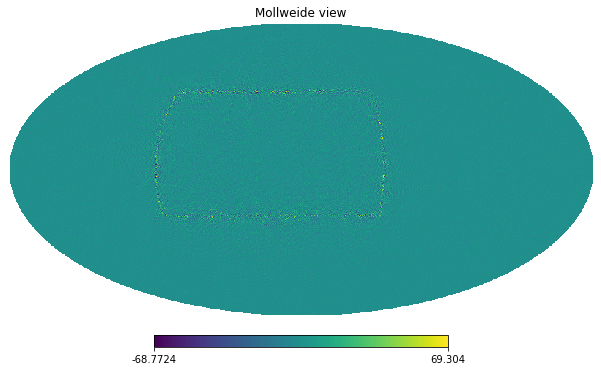

In [77]:
hp.mollview(residual)